In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Bimodal distribution

We wish to solve the inverse problem $$ \nu_i = \sum_j R_{ij} \mu_j + \beta_i $$ for $\mu_i$ given data $n_i$ with expectation value $E[n_i] = \nu_i$.

First, generate some $\mu$ (truth), $\nu$ (reco), $n$ (data). We set $\beta=0$ for this example.

## 1. Generate example data

Consider a double-hump spectrum made by the sum of two Gaussians. This is generated by the `generate_double_peak(n_samples, smear)` function. It also returns a reco sample with Gaussian noise of amplitude `smear`.

In [2]:
def generate_double_peak(size, smear):
    peak1 = np.random.normal(0.3, 0.1, int(size/2))
    peak2 = np.random.normal(0.7, 0.1, int(size/2))
    truth = np.random.permutation(
        np.concatenate([peak1, peak2]))
    smeared = np.random.normal(truth, smear)

    return pd.DataFrame({'truth': truth, 'reco': smeared})

In [3]:
np.random.seed(420)
df = generate_double_peak(20000, .075)
truth = df.truth.values
reco = df.reco.values

In [4]:
# Bin definitions: we need edges, centers, and under/overflow
bins = np.linspace(0., 1., 20+1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Extend bins out to ±inf to absorb under/overflow
extended_bins = np.concatenate([np.concatenate([[-np.inf], bins, [np.inf]])])

In [5]:
# Histogram the truth/reco samples
truth_hist, be = np.histogram(truth, bins=extended_bins)
reco_hist, be = np.histogram(reco, bins=be)

# Generate pseudo-data by Poisson sampling from the reco distribution
data = np.random.poisson(reco_hist)

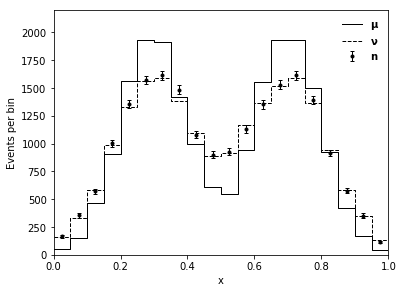

In [6]:
from helpers import plot_hist

# Plot our unfolding ingredients
plt.figure(figsize=(6,4.5))
plot_hist(truth_hist, bins, label='$\mathbf{\mu}$', color='k', lw=1, zorder=0)
plot_hist(reco_hist, bins, label=r'$\mathbf{\nu}$', linestyle='--', lw=1, color='k', zorder=1)
plt.errorbar(bin_centers, data[1:-1], yerr=np.sqrt(data[1:-1]), fmt='ok', ms=3, capsize=2, lw=1, label='$\mathbf{n}$', zorder=2)
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.ylim(0, 2200)
plt.show()

## 2. Response matrix

The response matrix is defined as $R_{ij} = P(\text{observed in bin } i \, | \, \text{true value in bin } j)$.

In [7]:
def response_matrix(truth, reco, bins):
    r = np.histogram2d(reco, truth, bins=bins)[0]
    norm = r.sum(axis=0, keepdims=True)
    return r / norm

R = response_matrix(truth, reco, extended_bins)

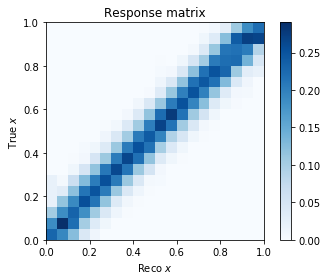

In [8]:
plt.imshow(R[1:-1,1:-1], cmap='Blues', origin='lower', extent=(0,1,0,1))
plt.colorbar()
plt.title('Response matrix')
plt.xlabel('Reco $x$')
plt.ylabel('True $x$')
plt.show()

### 2.5 ML solution

The maximum likelihood solution is given by $\mu_{ML} = R^{-1}n$, with covariance matrix $U_{ML} = R^{-1}V(R^{-1})^T$.

In [9]:
import scipy.linalg
mu_ML = scipy.linalg.solve(R, data)

V = np.diag(reco_hist)
R_inv = scipy.linalg.inv(R)
U = np.dot(R_inv, np.dot(V, R_inv.T))

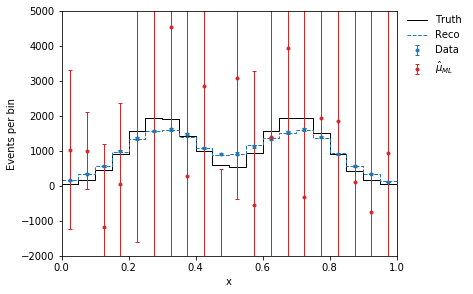

In [10]:
plt.figure(figsize=(6,4.5))
plot_hist(truth_hist, bins, label='Truth', color='k', lw=1, zorder=0)
plot_hist(reco_hist, bins, label='Reco', linestyle='--', lw=1, color='C0', zorder=1)
plt.errorbar(bin_centers, data[1:-1], yerr=np.sqrt(data[1:-1]), fmt='oC0', ms=3, capsize=2, lw=1, label='Data', zorder=2)
plt.errorbar(bin_centers, mu_ML[1:-1], yerr=np.sqrt(np.diag(U)[1:-1]), fmt='oC3', ms=3, capsize=2, lw=1, label='$\hat{\mu}_{ML}$')
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.ylim(-2000, 5000)
plt.show()

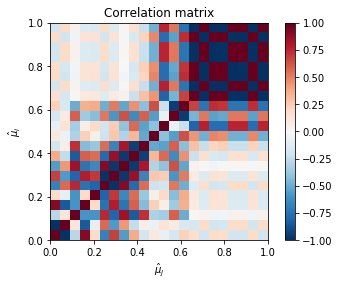

In [11]:
corr = U / np.sqrt(U.diagonal() * U.diagonal().reshape((-1 ,1)))

plt.imshow(corr,origin='lower', extent=(0, 1, 0, 1), vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Correlation matrix')
plt.colorbar()
plt.xlabel('$\hat{\mu}_j$')
plt.ylabel('$\hat{\mu}_i$')
plt.show()

We conclude that the ML solution is inadequate for this example and there is a need for regularisation.

## 3. Gaussian Processes

### Background

Following **Rasmussen & Williams [1]**, a zero-mean prior distribution with covariance (kernel) function $k(x,x^\prime)$ is conditioned on observations $\bf y$ (with noise $\sigma_n$) at indices $X$ to give the posterior distribution
$$\begin{align} {\bf f}_* \, | \, X, {\bf y}, X_*  \sim \mathcal{N}(& K_*^\mathsf{T}[K + \sigma_n^2 I]^{-1} {\bf y}, K_{**} - K_*^\mathsf{T}[K + \sigma_n^2 I]^{-1} K_*), \\ \, \end{align}$$
for predictions $\bf f_*$ at $X_*$, where $K_{ij} = k(X_i, X_j)$, $K_{*ij} = k(X_i, X_{*j})$, $K_{**} = k(X_{*i}, X_{*j})$, and $\mathcal{N}(\mu, \sigma^2)$ is the normal distribution with mean $\mu$ and (co)variance $\sigma^2$.

The solution is easy to find, and we get the covariance for little extra work. In fact, using Cholesky decomposition to invert the positive semidefinite factor $K + \sigma_n^2 I$, the algorithm runs in time $\mathcal O(n)$, where $n$ is the number of observations. Note also that the GP is a _regressor_, i.e. we are not restricted to particular values of $X_*$. In fact, the solution is a continuous function.

Define training (observation) points $X$ and finely-spaced test (prediction) points $X_*$ (used later below).

In [12]:
# Add over/underflow bin centers (lying just outside tgw plot limits)
Xtrain = np.append(-bin_centers[0], bin_centers)
Xtrain = np.append(Xtrain, bin_centers[-1] + bin_centers[0]*2).reshape(-1, 1)

Xtest = np.linspace(Xtrain[0], Xtrain[-1], 500).reshape(-1, 1)

### Relationship to regularisation

In inverse problems, the regularisation viewpoint considers the functional $$ \phi[f] = \alpha \log L[f] + S[f], $$ where $\alpha$ is a regularisation parameter controlling the smoothness of the maximum-$\phi$ solution.

Here $L[f]$ is a likelihood quantifying the goodness-of-fit to observations.

A common choice for the regularisation functional $S[f]$ is a mean of the square of some derivative of $f$. In HEP, we call this _Tikhonov_ [2] regularisation and commonly choose the second derivative
$$ S[f(y)] = -\int \left( \frac{\mathrm{d}^2 f(y)}{\mathrm{d}y^2} \right)^2 \, \mathrm{d}y. $$

In statistics, this specific case is _spline regularisation_. Skipping over a lot of maths and following Refs. **[1]** and **[3]**, the equivalent stationary (a function of $r = x - x^\prime$) GP kernel is given by the Green's function that solves the problem
$$ \frac{\partial^4}{\partial r^4} k(r) = \delta(r). $$
The general solution is $$k(r) = \frac{1}{6}|r|^3 + a_3 r^3 + a_2 r^2 + a_1 r + a_0.$$ The coefficients of odd terms are 0 due to the positive semidefinite constraint on the kernel. We further require that $k(r) \rightarrow 0$ as $r \rightarrow \infty$, but this seems impossible for this solution. However, by restricting to a domain $\Omega$, we can require that $k(R) = 0$ and $\partial{k}(R)/\partial{r} = 0$, where $R$ is the maximum value of $r$ in the domain. Then the solution is $$k(r) = \frac{\alpha}{12}(2|r|^3 - 3Rr^2 + R^3),$$ where the regularisation parameter $\alpha$ has been inserted to control the smoothness of the allowed solutions.

In [13]:
from scipy.linalg import cho_factor, cho_solve, solve

def tikhonovKernel(a, b, params):
    R = Xtrain[-1] - Xtrain[0] + np.finfo(float).eps # Maximum difference
    r = a - b.T
    return (2*np.abs(r)**3 - 3*R*(r**2) + R**3) * (np.exp(params)/12)    

def sqExpKernel(a, b, params):
    amp, param = params
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(amp) * np.exp(-.5 * (1/param) * sqdist)

def GP_predict(params, Xsamp=Xtest, kernel=sqExpKernel, mean=True, data=data):
    V = np.diag(reco_hist)
    U = np.dot(np.linalg.inv(R), np.dot(V, np.linalg.inv(R).T))
    
    K = kernel(Xtrain, Xtrain, params)
    Ks = kernel(Xsamp, Xtrain, params)
    Kss = kernel(Xsamp, Xsamp, params)
    
    L = cho_factor(K + U)
    if mean:
        alpha = solve(np.dot(R, K+U), data - reco_hist)
        mu = np.dot(Ks, alpha) + truth_hist
    else:
        alpha = solve(np.dot(R, K+U), data)
        mu = np.dot(Ks, alpha)   
    
    cov = Kss - np.dot(Ks, cho_solve(L, Ks.T))
    return mu, cov

The marginal likelihood is easily computed as
$$ \log P({\bf n} \, | \, X, R) = -\frac{1}{2} (R^{-1}{\bf n})^\mathsf{T} (K + U)^{-1} R^{-1} {\bf n} - \frac{1}{2} \log |K+U| - \frac{n}{2}\log 2\pi. $$
We can maximise this as a function of the regularisation parameters.

In [14]:
def llh(params, kernel=sqExpKernel):
    V = np.diag(reco_hist)
    U = np.dot(np.linalg.inv(R), np.dot(V, np.linalg.inv(R).T))
    
    K = kernel(Xtrain, Xtrain, params)
    alpha = solve(np.dot(R, K+U), data)
    t = np.dot(np.linalg.inv(R), data)
    return np.dot(t, alpha) + np.log(np.linalg.det(K+U))

In [15]:
from scipy.optimize import minimize

kernel = sqExpKernel
x0 = [17.0, 1e-3]

res = minimize(llh, x0, method='L-BFGS-B', args=kernel)
print(res)

      fun: 337.7683438594082
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00052296,  0.0108912 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 13
   status: 0
  success: True
        x: array([13.94540947,  0.0197445 ])


#### Marginal LH surface plot

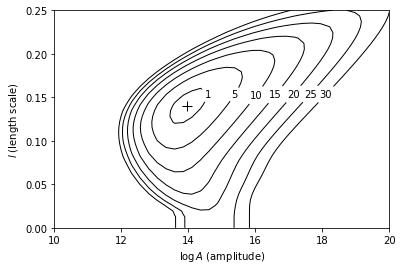

In [16]:
nsamp = 40
x = np.linspace(10, 20, nsamp)
y = np.linspace(1e-12, 0.25, nsamp)
X, Y = np.meshgrid(x, y)
Z = np.asarray([[llh((xi, yi**2)) - llh(res.x) for xi in x] for yi in y])

contours = [1, 5, 10, 15, 20, 25, 30]
CS = plt.contour(X, Y, Z, contours, colors='k', linewidths=1)
label_y = 0.15
manual_locs = [(14.85, label_y), (15.5, label_y), (16.1, label_y), (16.7, label_y), (17.25, label_y), (17.75, label_y), (18.2, label_y)]
labels = plt.clabel(CS, fmt='%1.0f', manual=manual_locs)
for label in labels: label.set_rotation(0)
    
plt.plot(res.x[0], np.sqrt(res.x[1]), 'k+', ms=10)

plt.xlabel('$\log \, A$ (amplitude)')
plt.ylabel('$l$ (length scale)')

# plt.tick_params(top=True, right=True, direction='in')

plt.show()

## 4. GP Unfolding

In [17]:
mu, cov = GP_predict(res.x, Xtrain, mean=False)
std = np.sqrt(np.diag(cov))

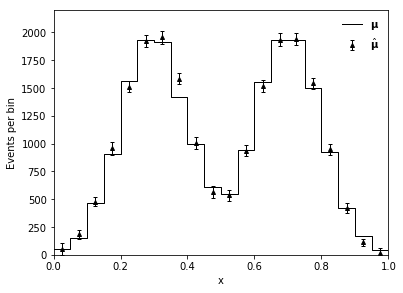

In [18]:
plt.figure(figsize=(6,4.5))
plot_hist(truth_hist, bins, label='$\mathbf{\mu}$', color='k', lw=1, zorder=0)
plt.errorbar(bin_centers, mu[1:-1], yerr=std[1:-1], fmt='^k', ms=4, capsize=2, lw=1, label='$\hat\mathbf{\mu}$', zorder=2)
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.ylim(0, 2200)
plt.savefig('result.pdf', bbox_inches='tight')

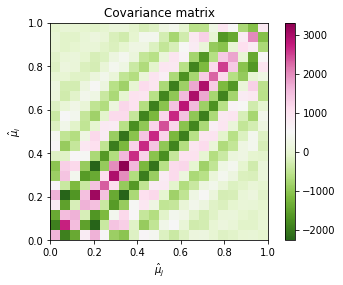

In [19]:
plt.imshow(cov, origin='lower', extent=(0, 1, 0, 1), cmap='PiYG_r')
plt.title('Covariance matrix')
plt.xlabel('$\hat{\mu}_j$')
plt.ylabel('$\hat{\mu}_i$')
plt.colorbar()
plt.show()

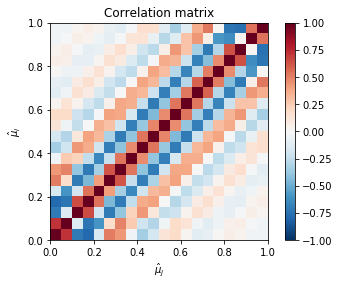

In [20]:
corr = cov / np.sqrt(cov.diagonal() * cov.diagonal().reshape((-1 ,1)))

plt.imshow(corr[1:-1,1:-1], origin='lower', extent=(0, 1, 0, 1), vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Correlation matrix')
plt.xlabel('$\hat{\mu}_j$')
plt.ylabel('$\hat{\mu}_i$')
plt.colorbar()
plt.show()

## 5. Varying regularisation

Using the Tikhonov kernel, we can vary the regularisation parameter $\alpha = \exp(\gamma)$.

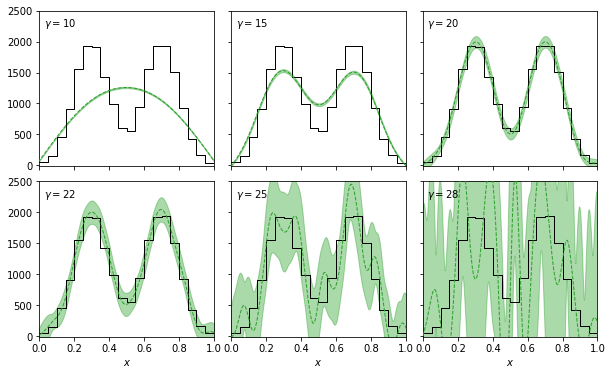

In [21]:
gammas = [10, 15, 20, 22, 25, 28]

fig, axarr = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in enumerate(axarr.flatten()):
    plot_hist(truth_hist, bins, ax=ax, label='Truth', color='k', lw='1')
    mu, cov = GP_predict(gammas[i], kernel=tikhonovKernel, mean=False)
    std = np.sqrt(np.diag(cov))
    ax.plot(Xtest, mu, '--C2', ms=5, lw=1, zorder=20, label='$\hat{\mu}$')
    ax.fill_between(Xtest.flatten(), mu+std, mu-std, color='C2', alpha=0.4)
    ax.annotate('$\gamma={}$'.format(gammas[i]), xy=(.025, .9), xycoords='axes fraction')
    
for ax in axarr[-1]:
    ax.set_xlabel('$x$')
    ax.set_ylim(-10, 2500)
    
plt.show()

# References

1. C. E. Rasmussen, C. K. I. Williams, Gaussian Processes for Machine Learning, The MIT Press, 2006.
2. A. Tikhonov, On the solution of ill-posed problems and the method of regularization, Mat. Sb. 151 (3) (1963) 501–504.
3. O. Williams, A. Fitzgibbon, Gaussian process implicit surfaces, in: Proc. Gaussian Processes in Practice, 2007, pp. 1–4. URL https://www.microsoft.com/en-us/research/publication/gaussian-process-implicit-surfaces-2/